In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from math import ceil
from os import listdir

import sys
sys.path.append('../')

from src.sigmoid_activation import SigmoidActivation
from src.relu_activation import ReLUActivation
from src.softmax_activation import SoftmaxActivation
from src.log_error import LogError
from src.mean_squared_error import MeanSquaredError
from src.network import Network

d:\apps\python 3.7.2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
d:\apps\python 3.7.2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
d:\apps\python 3.7.2\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Read the data
full_df = pd.read_csv('../data/mnist/train.csv')

In [3]:
# Preprocess the data

full_set_size, no_features = full_df.shape
train_set_size = full_set_size // 2
validation_set_size = full_set_size // 4
test_set_size = full_set_size - train_set_size - validation_set_size

x = np.array(full_df.drop('label', axis=1)).astype(float)
y_as_no = np.array(full_df['label'])

# Normalize x to [0, 1] range
x_max = np.max(x)
if x_max != 0:
    x /= x_max
    
# One hot encoding
y = np.zeros((full_set_size, 10))
for row in range(full_set_size):
    y[row, y_as_no[row]] = 1

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


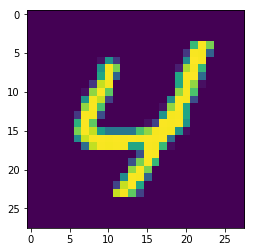

In [4]:
# Just to make sure everything is loaded correctly

chosen_val = 450
number = x[chosen_val].reshape((28, 28))
plt.imshow(number)
print(y[chosen_val, :])

In [5]:
# Split the set to train, validation and test set

train_x = x[:train_set_size, :]
train_y = y[:train_set_size]

validation_x = x[train_set_size:(train_set_size + validation_set_size)]
validation_y = y[train_set_size:(train_set_size + validation_set_size)]

test_x = x[(train_set_size + validation_set_size):]
test_y = y[(train_set_size + validation_set_size):]

In [6]:
# Function to measure how many predictions were correct

def compare_predictions(predictions, y):
    examples, no_classes = y.shape
    
    summed = np.sum((predictions == y).astype(int), axis=1)
    return np.sum(summed == no_classes).astype(int)
    #return count / examples

# One hot encoding on network outputs
def hard_max(predictions):
    answers = np.argmax(predictions, axis=1)
    ret = np.zeros(predictions.shape)
    
    for example in range(predictions.shape[0]):
        ret[example, answers[example]] = 1.0
    return ret

In [20]:
# Initialize the networks

input_size = train_x.shape[1]
output_size = 10
no_networks = 5

layers = []
layers.append([(input_size, ReLUActivation(), True),
               (500, ReLUActivation(), True),
               (output_size, SoftmaxActivation(), True)])

layers.append([(input_size, SigmoidActivation(), True),
               (500, SigmoidActivation(), True),
               (output_size, SoftmaxActivation(), True)])

layers.append([(2500, ReLUActivation(), True),
               (output_size, SoftmaxActivation(), True)])


layers.append([(input_size, ReLUActivation(), True),
               (500, ReLUActivation(), True),
               (500, ReLUActivation(), True),
               (500, ReLUActivation(), True),
               (output_size, SoftmaxActivation(), True)])

networks = [[Network(input_size, layers[i], LogError()) for _ in range(no_networks)] for i in range(len(layers))]
train_loss_histories = [[[] for _ in range(no_networks)] for _ in range(len(layers))]
validation_loss_histories = [[[] for _ in range(no_networks)] for _ in range(len(layers))]

## Run the 'training' cell to compute new networks.
## Run the 'load from file' cell to load previously computed networks and loss history.

In [21]:
# Load from file

path = '../results/mnist/'
for file in listdir(path):
    _, layer_no, net_no = file.split('_')
    layer_no, net_no = int(layer_no), int(net_no[:-4])
    with open(path + file, 'rb') as f:
        dic = pickle.load(f)
        networks[layer_no][net_no] = dic['network']
        train_loss_histories[layer_no][net_no] += dic['train']
        validation_loss_histories[layer_no][net_no] += dic['validation']

In [15]:
# Training

batch_iterations = 1000
batch_size = 512
validation_batch_size = 4096
full_iterations = 0
alpha = 0.01

for layer_type in range(len(layers)):
    for net_no, network in enumerate(networks[layer_type]):
        if layer_type == 3 and net_no == 0:
            continue
        file_path = '../results/mnist/layer_{}_{}.dat'.format(layer_type, net_no)
        train_loss_history = []
        validation_loss_history = []
        for i in range(batch_iterations + full_iterations):
            if i < batch_iterations:
                train_loss = network.fit(train_x, train_y, alpha=alpha, batch_size=batch_size)
            else:
                train_loss = network.fit(train_x, train_y, alpha=alpha, batch_size=train_set_size)
            if i % 50 == 0:
                validation_loss = network.evaluate(validation_x, validation_y, batch_size=validation_batch_size)
                validation_loss_history.append(validation_loss)

            train_loss_history.append(train_loss)

            print("\rLayer type: {}, network no: {}, iteration {}/{}"
                  .format(layer_type, net_no, i, batch_iterations + full_iterations), end='')

        train_loss_histories[layer_type][net_no] += train_loss_history
        validation_loss_histories[layer_type][net_no] += validation_loss_history
        network.clear_tmp_values()
        with open(file_path, 'wb') as f:
            pickle.dump({'train': train_loss_histories[layer_type][net_no],
                         'validation': validation_loss_histories[layer_type][net_no],
                         'network': network}, f)

Layer type: 3, network no: 4, iteration 999/1000

Layer 0


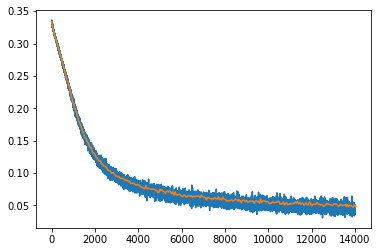

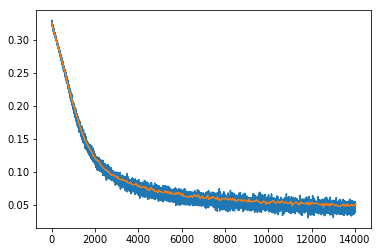

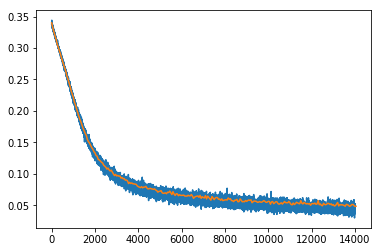

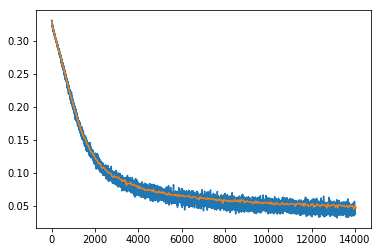

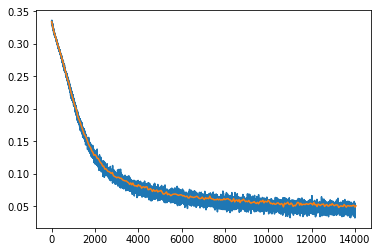

Layer 1


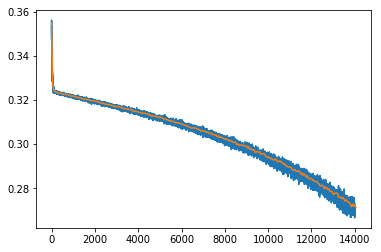

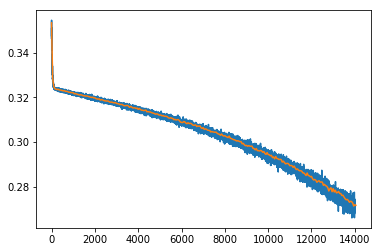

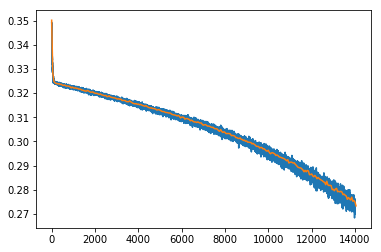

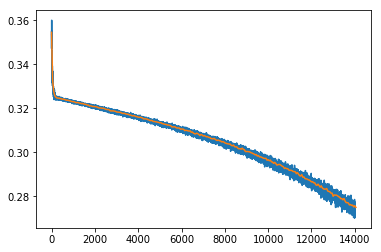

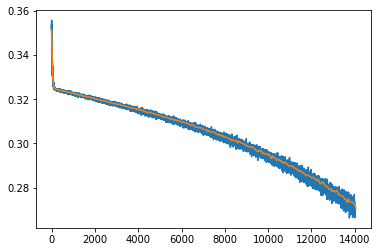

Layer 2


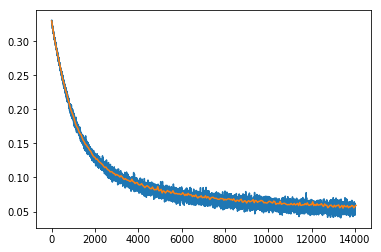

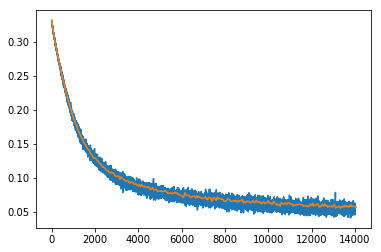

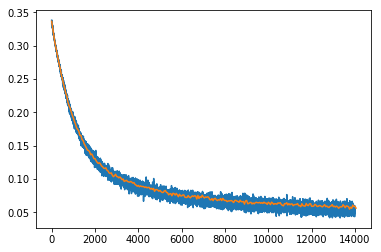

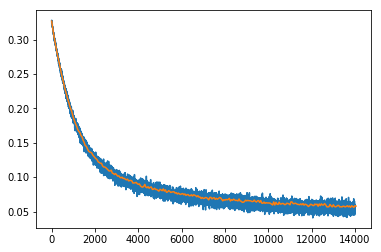

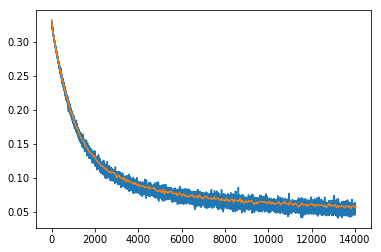

Layer 3


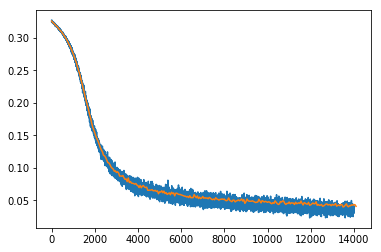

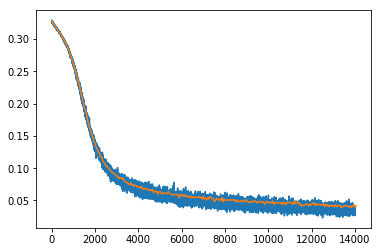

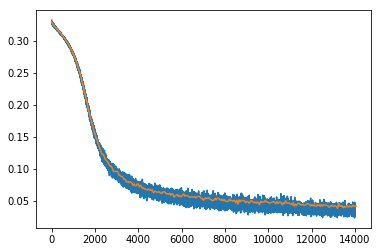

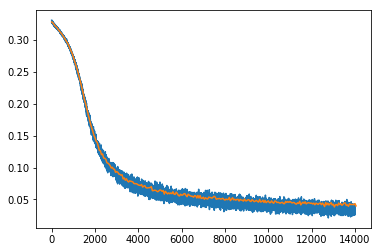

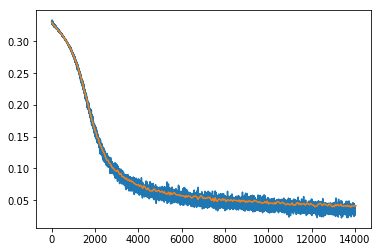

In [22]:
validation_interval = 50
for layer_type in range(len(layers)):
    print("Layer {}".format(layer_type))
    for net_no, network in enumerate(networks[layer_type]):
        plt.plot(train_loss_histories[layer_type][net_no])
        x_range = [50*i for i in range(len(validation_loss_histories[layer_type][net_no]))]
        plt.plot(x_range, validation_loss_histories[layer_type][net_no])
        plt.show()

In [ ]:
# Let's see how well we do on the test set
scores = [[0 for _ in range(no_networks)] for _ in range(len(layers))]
for layer_type in range(len(layers)):
    for net_no, network in enumerate(networks[layer_type]):
        predictions = hard_max(network.predict(test_x))
        correct = compare_predictions(predictions, test_y)
        scores[layer_type][net_no] = correct / test_set_size
        print("Layer type {}, net no {}, prediction score: {}"
              .format(layer_type, net_no, correct / test_set_size))

Layer type 0, net no 0, prediction score: 0.9207619047619048
Layer type 0, net no 1, prediction score: 0.9224761904761904
Layer type 0, net no 2, prediction score: 0.9221904761904762
Layer type 0, net no 3, prediction score: 0.9211428571428572
Layer type 0, net no 4, prediction score: 0.9193333333333333


In [ ]:
# Calculate average score and variance for each layer type
for layer_type in range(len(layers)):
    average = sum(scores[layer_type]) / no_networks
    variance = sum([((average - scores[layer_type][i])**2) for i in range(no_networks)])\
                    / no_networks
    print("Layer {}: average = {}, variance = {}"
          .format(layer_type, average, variance))